## Graduation Research 

## Conduct PCA

In [ ]:
# 1次元に引き延ばす
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test, channel):
    """
    分類分布をPCAにて取得
    """
    for i in range(4):
        images = activations[i,:,:,:]
        if i == 0:
            labels = y_test[:channel]
        elif i == 1:
            labels = y_test[channel:channel*2]
        elif i == 2:
            labels = y_test[channel*2:channel*3]
        elif i == 3:
            labels = y_test[channel*3:]
        ls = []
        for label in labels:

            if list(label) == [1,0,0,0]:
                ls.append("class_A")
            elif list(label) == [0,1,0,0]:
                ls.append("class_B")
            elif list(label) == [0,0,1,0]:
                ls.append("class_C")
            elif list(label) == [0,0,0,1]:
                ls.append("class_D")
                
        labels = ls
        print(labels)
        data = []
        for a in range(channel):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)
        """
        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]
        """
        
        pca = PCA(n_components=2)
        X = pca.fit_transform(data)

        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_A")})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_B")})
        elif i == 2:
            df3 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_C")})
        elif i == 3:
            df4 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_D")})
        
    df = pd.concat([df1, df2,df3,df4])
        
    colors = ['red','blue','green','fuchsia']
    plt.figure(figsize=(10, 10))
    print(df)
    print(df['label'].unique())

    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature.png')
    """
    # training a classifier                                                                                                 
    pca = PCA(n_components=4)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
    
def conduct_pca():

    """
    PCAにより可視化する
    """
    
    urls = ["/home/seimei/Graduation_Research/dataset_valid/kumori/class_A5/image_0005.jpg",
            "/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg", 
            "/home/seimei/Graduation_Research/dataset_valid/kumori/kumori_C5/image_0001.jpg",
    "/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"]

    test_labels = keras.utils.to_categorical(np.r_[np.zeros(channel), np.ones(channel),np.full(channel,2),np.full(channel,3)])
    handle_image_with_pca(activations, test_labels, channel)



## Conduct Grad-CAM

In [4]:
def grad_cam(input_model, image, category_index, layer_name):
    
    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    conv_output =model.layers[9].output #model.layers[5].output 
    print(conv_output)
    #print(conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output)
    
    loss = KTF.sum(model.layers[-1].output)
    print("~~~~~~")

    grads = normalize(KTF.gradients(loss, conv_output)[0])
    gradient_function = KTF.function([model.layers[0].input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    #多分GAP
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w*(255*output[:, :, i])

    cam = cv2.resize(cam, (300, 300))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    
    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam1 = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam1) + np.float32(255*image)
    cam = 255 * cam / np.max(cam)
    cv2.imwrite("heat.jpg",cam1)
    return np.uint8(cam), heatmap

    
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, KTF.one_hot([category_index], nb_classes))


def target_category_loss_output_shape(input_shape):
    return input_shape


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (KTF.sqrt(KTF.mean(KTF.square(x)) + 1e-5))


def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
 #   x = preprocess_input(x)
    return x


def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) *  tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_8'):

    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    #各特徴マップの中より予測により影響を与えているものを選別
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])
    
    #return KTF.function([input_img, KTF.learning_phase()], [saliency])

#guided backpropっぽい
def modify_backprop(model, name):

    g = tf.get_default_graph()

    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation                              # 'hasttr() = activation'属性を持っているのかTrue of Falseで返す
        layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        print(layer_dict)
        # replace relu activation
        for layer1 in layer_dict:
            if layer1.activation == keras.activations.relu:
                layer1.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = model
    return new_model


def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if KTF.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    # 0~255に正規化    
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def conduct_gradcam(model):

    """
    Grad-CAMの実行
    """
    
    url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0049.jpg"
#"/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg"
#"/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
#'/home/seimei/Graduation_Research/dataset/kumori/kumori_D2/image_0001.jpg'  なるほどね
#"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0189.jpg"
#"/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg"
#"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0024.jpg"
    img = image.img_to_array(img_to_matrix(url))
    img.astype('float32')
    img /= 255.0
    img = np.expand_dims(img,axis=0)
       # preprocessed_input = load_image("/home/seimei/image_0058_brush.jpg")
    predictions=model.predict(img)#np.expand_dims(img, axis=0))

    predicted_class= np.argmax(predictions)

    print(predicted_class)
    print(predictions)

    cam, heatmap = grad_cam(model, img, predicted_class, "conv2d_6")
    cv2.imwrite("gradcam.jpg", cam)
    cv2.imwrite("test_heatmap.jpg", heatmap)
    register_gradient()
    guided_model = modify_backprop(model, 'GuidedBackProp')
    saliency_fn = compile_saliency_function(guided_model)
    saliency = saliency_fn([img,0])#[np.expand_dims(img, axis=0), 0])
    print(saliency)
    gradcam = saliency[0] * heatmap[..., np.newaxis]
    cv2.imwrite("backprop.jpg",gradcam)
    #  print(type(gradcam))
    cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))


## Main Code

In [2]:
import tensorflow as tf
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
from keras.preprocessing import image
import keras

from keras.models import load_model
import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16, preprocess_input 
#https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras                                                                                                            

from PIL import Image
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

from PIL import ImageFile
import math


from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import numpy as np
import keras 
import sys 
import cv2


import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.applications.resnet50 import (ResNet50, preprocess_input)
from keras.preprocessing import image
% matplotlib inline 

import sys
#from matplotlib_util import save_model_to_file


import ast
import numpy as np
import math
import random
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img


Using TensorFlow backend.


##  TFRecord fileにimage data及びlabelをdump

In [2]:
# TFRecord fileに画像データ及びラベルをdumpする

IM_SIZE=300
# Serialize images, together with labels, to TF records
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _create_tfrecord(mode):
    tf_records_filename = './input_pipline/outdoor_shisa_TFRecord_{}.tfrecords'.format(mode)
    writer = tf.python_io.TFRecordWriter(tf_records_filename)

    # List of image paths, np array of labels
    df_train = pd.read_csv("./input_pipline/path_and_label_{}.csv".format(mode))
    im_list= [v for v in df_train['path'].tolist()]
    labels_arr= np.array([v for v in df_train["label"].tolist()])
    labels_arr= keras.utils.to_categorical(labels_arr, 4)

    # Loop over images and labels, wrap in TF Examples, write away to TFRecord file
    for i in range(len(df_train)):
        labels = labels_arr[i].astype(np.float32) 
        im=np.array(img_to_array(load_img(im_list[i], target_size=(IM_SIZE,IM_SIZE)))/255.)

        example = tf.train.Example(features=tf.train.Features(feature={'image': _bytes_feature(im.tostring()),
                                                                     'labels': _bytes_feature(labels.tostring())}))
        writer.write(example.SerializeToString())
    writer.close()

_create_tfrecord('test')    


KeyboardInterrupt: 

In [6]:

IM_SIZE=300

# clone した convnet-drawer ディレクトリのパスを追加する。
sys.path.append('convnet-drawer')

#画像がPILでロードできない問題について
# PILは極端に大きな画像など高速にロードできない画像はロードしないで見過ごす仕様になっている故の解決法
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 使用するGPUの割り当てを決定する
config = tf.ConfigProto(device_count={'GPU':0 ,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)


STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'


#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              

input_shape = (300, 300, 3)
batch_size = 32
epochs = 10
num_classes = 4

f_log = './logs/object_classificationAB/'
f_model = './model/test/'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'


def img_to_matrix(filename, verbose=False):
    """
    parse image            
    """
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


    
def tf_image_translate(images, tx, ty, interpolation="NEAREST"):
    """
    Data Augmentation
    """
    # got these parameters from solving the equations for pixel translations
    # on https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform
    translations = [1, 0, -tx, 0, 1, -ty, 0, 0]
    return tf.contrib.image.translation(images, transforms, interpolation)
    
    """
    #augmentations
    if is_training():
        #color augmentations
        image = tf.image.random_brightness(image,max_delta=63)
        #image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed2) 
        #image = tf.image.random_hue(image, max_delta=0.2, seed=seed3)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
        
        tx = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)#正規分布によるランダム値 
        ty = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)
        image = tf_image_translate(image, tx=tx, ty=ty)
        
        degrees = tf.random_normal(shape=[], mean=0.0, stddev=5.0, dtype=tf.float32)
        image = tf.contrib.image.rotate(image, degrees*math.pi/180, interpolation="BILINEAR")
        
        
    """



def create_new_model(model):
    """
    モデルにおける活性化出力マップの操作(activation減衰)    
    """
    
    #消去するactivation(gradcam検出)   heatmap-ver 
    url="/home/seimei/Graduation_Research/src/heat.jpg"
    x=cv2.imread(url)
    img = cv2.resize(x,(150,150))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    masked=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    grad_activations=masked/255.
    


    grad_activations=np.expand_dims(grad_activations, axis=0)
    multi_grad_activation=(grad_activations[:,:,:,0]*grad_activations[:,:,:,1]*grad_activations[:,:,:,2])[0]
    multi_grad_activation=np.expand_dims(multi_grad_activation, axis=0)
    multi_grad_activation=np.expand_dims(multi_grad_activation, axis=3)
    # どうしようもないのでgrad_activationを64個追加して(1,150,150,64)を実現
    for i in range(6):
        multi_grad_activation= np.concatenate([multi_grad_activation,multi_grad_activation],axis=3)

    
    def my_init(shape,dtype='float32'):
        weights= model.get_layer("conv2d_1").get_weights()[0]
        print(weights.shape)
        return K.variable(value=weights,dtype=dtype)
    
    def bias(shape,dtype='float32'):
        weights1= model.get_layer("conv2d_1").get_weights()[1]        
        print(weights1.shape)
        return K.variable(value=weights1,dtype=dtype)
    
      
    def my_init1(shape,dtype='float32'):
        weights2= model.get_layer("conv2d_2").get_weights()[0]
        print(weights2.shape)
        return K.variable(value=weights2,dtype=dtype)
    
    def bias1(shape,dtype='float32'):
        weights3= model.get_layer("conv2d_2").get_weights()[1]        
        print(weights3.shape)
        return K.variable(value=weights3,dtype=dtype)
    
    
      
    def my_init2(shape,dtype='float32'):
        weights4= model.get_layer("conv2d_3").get_weights()[0]
        print(weights4.shape)
        return K.variable(value=weights4,dtype=dtype)
    
    def bias2(shape,dtype='float32'):
        weights5= model.get_layer("conv2d_3").get_weights()[1]        
        print(weights5.shape)
        return K.variable(value=weights5,dtype=dtype)
    
    
      
    def my_init3(shape,dtype='float32'):
        weights6= model.get_layer("conv2d_4").get_weights()[0]
        print(weights6.shape)
        return K.variable(value=weights6,dtype=dtype)
    
    def bias3(shape,dtype='float32'):
        weights7= model.get_layer("conv2d_4").get_weights()[1]        
        print(weights7.shape)
        return K.variable(value=weights7,dtype=dtype)
    
    
      
    def my_init4(shape,dtype='float32'):
        weights8= model.get_layer("conv2d_5").get_weights()[0]
        print(weights8.shape)
        return K.variable(value=weights8,dtype=dtype)
    
    def bias4(shape,dtype='float32'):
        weights9= model.get_layer("conv2d_5").get_weights()[1]        
        print(weights9.shape)
        return K.variable(value=weights9,dtype=dtype)
    
    
      
    def my_init5(shape,dtype='float32'):
        weights10= model.get_layer("conv2d_6").get_weights()[0]
        print(weights10.shape)
        return K.variable(value=weights10,dtype=dtype)
    
    def bias5(shape,dtype='float32'):
        weights11= model.get_layer("conv2d_6").get_weights()[1]   
        print(weights11.shape)
        return K.variable(value=weights11,dtype=dtype)
    
    
     
    def my_init6(shape,dtype='float32'):
        weights12= model.get_layer("conv2d_7").get_weights()[0]
        print(weights12.shape)
        return K.variable(value=weights12,dtype=dtype)
    
    def bias6(shape,dtype='float32'):
        weights13= model.get_layer("conv2d_7").get_weights()[1]
        print(weights13.shape)
        return K.variable(value=weights13,dtype=dtype)
    
      
    def my_init7(shape,dtype='float32'):
        weights14= model.get_layer("conv2d_8").get_weights()[0]
        print(weights14.shape)
        return K.variable(value=weights14,dtype=dtype)
    
    def bias7(shape,dtype='float32'):
        weights15= model.get_layer("conv2d_8").get_weights()[1]     
        print(weights15.shape)
        return K.variable(value=weights15,dtype=dtype)
    
    def my_init8(shape,dtype='float32'):
        weights16= model.get_layer("dense_1").get_weights()[0]
        print(weights16.shape)
        return K.variable(value=weights16,dtype=dtype)
    
    def bias8(shape,dtype='float32'):
        weights17= model.get_layer("dense_1").get_weights()[1]     
        print(weights17.shape)
        return K.variable(value=weights17,dtype=dtype)
    
    def my_init9(shape,dtype='float32'):
        weights18= model.get_layer("dense_2").get_weights()[0]
        print(weights18.shape)
        return K.variable(value=weights18,dtype=dtype)
    
    def bias9(shape,dtype='float32'):
        weights19= model.get_layer("dense_2").get_weights()[1]     
        print(weights19.shape)
        return K.variable(value=weights19,dtype=dtype)
    
     
    
    inputs=keras.layers.Input(shape=(300, 300, 3), name='input')
    conv_1=keras.layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init, bias_initializer=bias)(inputs)
    print(conv_1)
    conv_2=keras.layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init1,bias_initializer=bias1)(conv_1)
    maxp_1=keras.layers.MaxPooling2D(padding='same')(conv_2)
    
    
    conv_3=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init2, bias_initializer=bias2)(maxp_1)
    conv_4=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init3, bias_initializer=bias3)(conv_3)

    lam=keras.layers.Lambda(lambda x: tf.expand_dims(conv_4[0]*multi_grad_activation[0], 0)
                         ,output_shape=(150,150,64))(conv_4)     
    

    maxp_2=keras.layers.MaxPooling2D(padding='same')(lam)
   
    conv_5=keras.layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init4, bias_initializer=bias4)(maxp_2)
    conv_6=keras.layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init5, bias_initializer=bias5)(conv_5)
    print(conv_6)
    maxp_3=keras.layers.MaxPooling2D()(conv_6)
    

    conv_7=keras.layers.Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init6, bias_initializer=bias6)(maxp_3)
    conv_8=keras.layers.Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',
                         kernel_initializer=my_init7, bias_initializer=bias7)(conv_7)
    maxp_4=keras.layers.MaxPooling2D()(conv_8)

    #Flatten the output of the convolutional layers
    conv_flat=keras.layers.Flatten()(maxp_4)
    
    fc_1=keras.layers.Dense(512,activation='relu',kernel_initializer=my_init8,bias_initializer=bias8)(conv_flat)
    fc_2=keras.layers.Dense(4,activation='softmax',kernel_initializer=my_init9,bias_initializer=bias9)(fc_1)
    
    new_model=keras.models.Model(inputs,fc_2)
    print(new_model.summary())
    
    return new_model


def main():


  #  old_session = KTF.get_session()

    tf.reset_default_graph()
    with tf.Graph().as_default():        

        session = tf.Session('')                
        KTF.set_session(session)
        #KTF.set_learning_phase(1)#(0 = test, 1 = train) これがGrad-CAMをダメにしていた。　Grad-CAM使うときはtest時コメントアウトすること
       # saver = tf.train.import_meta_graph("./tmp/model.ckpt.meta")
        #saver.restore(session, "./tmp/model.ckpt")

        """
        IM_SIZE=300
        image_input = tf.keras.Input(shape=(IM_SIZE, IM_SIZE, 3), name='input_layer')
        
        conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='elu')(image_input)
        conv_2 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='elu')(conv_1)
        conv_2 = tf.keras.layers.MaxPooling2D(padding='same')(conv_2)
        
        conv_3 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='elu')(conv_2)
        conv_4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='elu')(conv_3)
        conv_4 = tf.keras.layers.MaxPooling2D(padding='same')(conv_4)
        
        conv_5 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='elu')(conv_4)
        conv_6 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='elu')(conv_5)
        conv_6 = tf.keras.layers.MaxPooling2D(padding='same')(conv_6)
        
        conv_7 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='elu')(conv_6)
        conv_8 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='elu')(conv_7)
        conv_8 = tf.keras.layers.MaxPooling2D(padding='same')(conv_8)
        

            
        # Flatten the output of the convolutional layers
        conv_flat = tf.keras.layers.Flatten()(conv_8)

        fc_1 = tf.keras.layers.Dense(128, activation='elu')(conv_flat)
        fc_1 = tf.keras.layers.Dropout(0.2)(fc_1)
        
        fc_2 = tf.keras.layers.Dense(128, activation='elu')(fc_1)
        fc_2 = tf.keras.layers.Dropout(0.2)(fc_2)
        
        #Output layers: separete outputs for  the weather and the labels
        output = tf.keras.layers.Dense(4, activation='softmax', name='shisa')(fc_2)

        #Wrap in a Model
        model = tf.keras.Model(inputs=image_input, outputs=[output])
    
        #load trained model                                                                                                
        """
        
        #model = tf.keras.models.load_model('./model/')
        model = load_model('./model/test/Mymodel2.h5')   
        
        for i in model.layers:
            print(i.name)
            print(i)

        #('./model/test_elu/Mymodel2.h5')
        #('./model/test_relu/Mymodel2.h5')
        #('./model/test/Mymodel2.h5')
        print(model.summary())
        new_model=create_new_model(model)
        print(id(model))
        
        print(id(new_model))
     #   save_model_to_file(model,'4class_shisa_net.pdf')

        """
        model.compile(optimizer='SGD',
                     loss={'shisa': 'categorical_crossentropy'},
                     metrics=['accuracy'])
        print(model.summary())         
        
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint('./ModelCheckpoint/model.h5',verbose=1),
            tf.keras.callbacks.TensorBoard(log_dir='./logs/',
                                          histogram_freq=0),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=5)
        ]
        
        
        # TFRecord fileを tf.data APIを使用しparseする
        
        featdef ={
            'image': tf.FixedLenFeature(shape=[], dtype=tf.string),
            'labels': tf.FixedLenFeature(shape=[], dtype=tf.string)
        }

        
        def _parse_record(example_proto, clip=False):
            example = tf.parse_single_example(example_proto, featdef)
            im = tf.decode_raw(example['image'], tf.float32)
            im = tf.reshape(im, (IM_SIZE, IM_SIZE, 3))
            label = tf.decode_raw(example['labels'], tf.float32)
            return im, label

        # Construct a TFRecordDataset
        ds_train = tf.data.TFRecordDataset('./input_pipline/outdoor_shisa_TFRecord_train.tfrecords').map(_parse_record)
        ds_train = ds_train.shuffle(1000).batch(32).repeat(-1)
        
        #Construct a TFRecordDataset
        ds_test = tf.data.TFRecordDataset('./input_pipline/outdoor_shisa_TFRecord_test.tfrecords').map(_parse_record)
        ds_test = ds_test.shuffle(1000).batch(32).repeat(-1)
        
        history = model.fit(ds_train,
                           validation_data=ds_test,
                           steps_per_epoch=129,
                           epochs=50,
                           verbose=True,
                           callbacks=callbacks,
                           validation_steps=129)        

        score_train = model.evaluate(ds_train, steps=129,verbose=1)
        score_test = model.evaluate(ds_test, steps=129,verbose=1)     
        print("Train_loss:{}".format(score_train[0]))
        print("Train_acc:{}".format(score_train[1]))
        print("Test_loss:{}".format(score_test[0]))
        print("Test_acc:{}".format(score_test[1]))        
        
        #model.save('./model/test_elu/Mymodel2.h5')
        model.save('./model/newmodel_master/newmodel.h5')

        #テスト画像全ての正誤を取得
       # check_accuracy_rate(model)
   # KTF.set_session(old_session)
 
     
        """

        url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0049.jpg"
        img = image.img_to_array(img_to_matrix(url))
        img.astype('float32')
        img /= 255.0
        img = np.expand_dims(img,axis=0)
           # preprocessed_input = load_image("/home/seimei/image_0058_brush.jpg")
        predictions=model.predict(img)#np.expand_dims(img, axis=0))

        predicted_class= np.argmax(predictions)
        print("")
        print("")
        print("model1:{}".format(predicted_class))
        print("model1:{}".format(predictions))

        print("model1_get_weights():{}".format(model.get_layer("conv2d_1").get_weights()[0][0,0,0,0]))
        predict = new_model.predict(img)
        predict_class=np.argmax(predict)
        print("")
        print("")
        
        print("model2:{}".format(predict_class))
        print("model2:{}".format(predict))
        print("model2_get_weights():{}".format(new_model.get_layer("conv2d_1").get_weights()[0][0,0,0,0]))

        session.close()
    sess.close()

if __name__ == '__main__':
    main()


conv2d_1
conv2d_2
max_pooling2d_1
conv2d_3
conv2d_4
max_pooling2d_2
conv2d_5
conv2d_6
max_pooling2d_3
conv2d_7
conv2d_8
max_pooling2d_4
flatten_1
dense_1
dense_2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64

In [58]:
! dot -?
140235774913504
140235758066152


/bin/sh: 1: dot: not found


## 誤分類したデータをcount

In [ ]:
def check_accuracy_rate(model):
    """
    誤分類のデータをカウント
    """
    
    path_and_label_and_weather = []
    with open("./path_and_label_test.txt","r") as s:
            image_urls=s.readlines()
    
    for i in image_urls:
            url_and_label=i.strip(" ").split(" ")
            image_url = url_and_label[0]
            image_label=url_and_label[1]
            img = image.load_img(image_url, target_size=(300,300))
            img=image.img_to_array(img)
            img.astype("float32")
            img/=255.0
            predictions=model.predict(np.expand_dims(img,axis=0))
            predicted_label=np.argmax(predictions)
            if int(predicted_label) != int(image_label):
                t=image_url.split("/")
                count=0
                for s in t:
                    if s=="dataset_valid":
                        name=t[count+1]
                    count+=1
                path_and_label_and_weather.append([image_url,name,predicted_label,int(image_label)])
                
                with open("./doc/incorrect_test_images.txt","a") as f:
                    f.write(image_url+"\n")

            elif int(predicted_label) == int(image_label) :
                if (predictions[0,predicted_label] < np.float32("0.7")):
                    with open("./doc/corret_test_images.txt","a") as g:
                        g.write(image_url+"\n")
            else:
                pass
    
    df = pd.DataFrame(path_and_label_and_weather,columns=["path","weater","predicted_label","label"])
    #df=df.set_index("weater")
    df.to_csv("./doc/incorrect_test_images.csv")


## visualize weights and feature maps

In [ ]:
def visualize_weights(model):
    """
    中間層におけるweightsの可視化を行う
    """
    
    img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg", target_size=(300, 300))  # 画像を読み込む。
    x = image.img_to_array(img)  # PIL オブジェクトを numpy 配列にする。
    x = np.expand_dims(x, axis=0)  # ミニバッチにするため、次元を追加する。
    x = preprocess_input(x)  # ResNet 用の前処理を行う。

    # モデルの3層目の出力を返す関数を作成する。
    get_feature_map = KTF.function([model.input, KTF.learning_phase()], [model.layers[3].output])
    print(model.layers[3].output)
    # 順伝搬して特徴マップを取得する。
    features = get_feature_map([x, False])[0]
    print('features.shape', features.shape)  # features.shape (1, 112, 112, 64)

    # 重みを取得する。
    [weights, bias] = model.layers[3].get_weights()
    print(model.layers[3])
    print('layer.name', model.layers[3].name)  # layer.name bn_conv1
    print('weights.shape', weights.shape)  # weights.shape (7, 7, 3, 64)
    print('bias.shape', bias.shape)  # bias.shape (64,)



    # 特徴マップをカーネルごとに分割し、画像化する。
    feature_imgs = []
    for f in np.split(features, 64, axis=3):
        f = np.squeeze(f, axis=0)  # (1, FeatureH, FeatureW, FeatureC) -> (FeatureH, FeatureW, FeatureC)
        f = image.array_to_img(f)  # 特徴マップを画像化する。
        f = np.array(f)  # PIL オブジェクトを numpy 配列にする。
        feature_imgs.append(f)
    weights = weights.transpose(3,2,0,1) #配列を転置
    nb_filter, nb_channel, nb_row, nb_col = weights.shape
    print("nb_filter:{}".format(nb_filter), "nb_channel:{}".format(nb_channel),"nb_row:{}".format(nb_row),"nb_col:{}".format(nb_col))
    from sklearn.preprocessing import MinMaxScaler
    plt.figure()
    for i in range(nb_filter):
        im=weights[i,0]
        #重みを0-255のスケールに変換
       # scaler=MinMaxScaler(feature_range=(0,255))
       # im = scaler.fit_transform(im)
        #プロットを1つの図にまとめる 

        plt.subplot(8,8,i+1)
        plt.axis('off')
        plt.imshow(im, cmap='gray')
    plt.savefig("weight.png")
    plt.show()
    
    cols = 6
    rows = int(len(feature_imgs) / cols)
    fig, axes = plt.subplots(rows, cols * 2, figsize=(100, 100))
    
     for r in range(rows):
        for c in range(cols):
            i = r * cols + c
            w_axis, f_axis = axes[r, c * 2], axes[r, c * 2 + 1]

            w_axis.imshow(weights[i,0],cmap='gray')
            w_axis.set_title('Kernel')
            w_axis.axis('off')

            f_axis.imshow(feature_imgs[i], cmap='gray')
            f_axis.set_title('Feature')
            f_axis.axis('off')
    plt.savefig("weight2.png")
    plt.show()
    
    
def visualize_intermediate_activation(model):
    """
    畳み込み層における活性化特徴マップの可視化を行う

    """

    # 　modelの各レイヤー 名を確認
    for i in model.layers:
        print(i.name)
    # modelのレイヤー名を指定
    layer_name ="conv2d_4"# "max_pooling2d_1"                                                                                
    # modelのレイヤー番号を指定
    layers = model.layers[3:4]     

    #　modelにおける中間層の出力を取得する
    intermediate_layer_model = keras.models.Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)            
    # modelに読み込ませる入力画像を指定
    urls=["/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0049.jpg"]
    width=150
    high=150
    channel=64
    activations = np.zeros((0,width,high,channel))

    img = image.load_img(url, target_size=(300, 300))
    img = image.img_to_array(img)
    img /= 255
    img = np.expand_dims(img, axis=0)
    # 指定したlayer_nameと一致するレイヤーの出力を取得する                     
    _activations = intermediate_layer_model.predict(img)
    _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
    print(np.shape(_activations))
    activations = np.r_[activations, np.reshape(_activations,(-1,width,high,channel))]
    
    print(np.shape(activations))
    # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
    for i, activation in enumerate(activations):
        num_of_image = activation.shape[2]
        cols = math.ceil(math.sqrt(num_of_image))
        rows = math.floor(num_of_image / cols)
        screen = []
        for y in range(0, rows):
            row = []
            for x in range(0, cols):
                j = y * cols + x
                if j < num_of_image:
                    #Grad-CAMで検出したnegative領域をactivationより直接的に消去する
                    #for i in range(3):
                    #    activation[:,:,j]*= img_hsv[:,:,i]

                    row.append(activation[:, :, j])
                else:
                    row.append(np.zeros())
            screen.append(np.concatenate(row, axis=1))
        screen = np.concatenate(screen, axis=0)
        plt.figure(figsize=(10, 10))

        # seabornでヒートマップ化
        sns.heatmap(screen, xticklabels=False, yticklabels=False)
        name = "maxpooling2d"
        plt.savefig("%s.png" % name)
        plt.plot()
        plt.close()


# About result

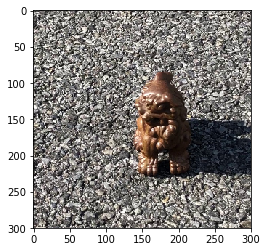

In [10]:
url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0049.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(300,300))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

(150, 150, 3)


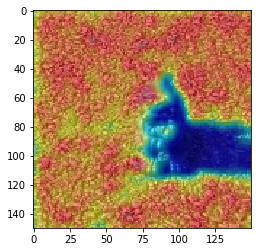

In [11]:
url="/home/seimei/Graduation_Research/src/gradcam.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(150,150))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_hsv=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)/255.
print(np.shape(img_hsv))
plt.imshow(img_hsv)

"""
model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:1
model2:[[0.19014715 0.50891834 0.14356905 0.15736546]]
model2_get_weights():-0.4142177700996399


"""

True

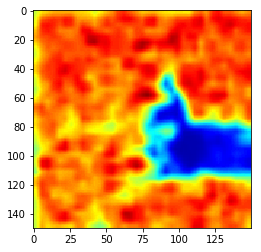

In [6]:
url="/home/seimei/Graduation_Research/src/heat.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(150,150))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
masked=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(masked)
cv2.imwrite("./h.jpg",masked)

(150, 150, 3)


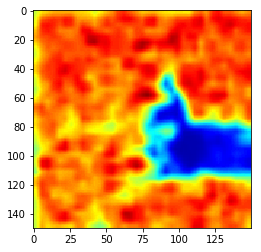

In [7]:
#正規化
masked=masked/255.
masked = cv2.resize(masked,(150,150))
print(np.shape(masked))
plt.imshow(masked)

"""

model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:1
model2:[[0.12617655 0.3858804  0.2818696  0.2060734 ]]
model2_get_weights():-0.4142177700996399

"""

## shadow detecter result

True

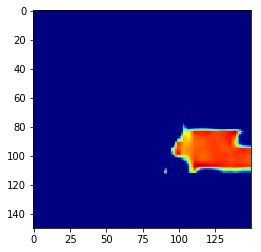

In [3]:
url="/home/seimei/Graduation_Research/src/heat.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(150,150))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
masked=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(masked)
cv2.imwrite("./h.jpg",masked)

(150, 150, 3)


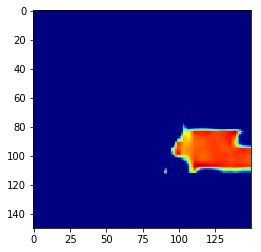

In [4]:
#正規化
masked=masked/255.
masked = cv2.resize(masked,(150,150))
print(np.shape(masked))
plt.imshow(masked)
"""

model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:0
model2:[[0.29580018 0.24254529 0.2179258  0.24372874]]
model2_get_weights():-0.4142177700996399

"""

(150, 150, 3)


True

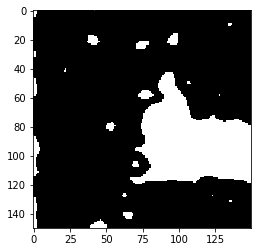

In [8]:
red_min = np.array([0,0,220], np.uint8)
red_max = np.array([255,255,255], np.uint8)
mask_red = cv2.inRange(img,red_min,red_max)
im = cv2.cvtColor(mask_red, cv2.COLOR_GRAY2RGB)
mask = cv2.bitwise_not(mask_red)
masked_arr=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255.
print(np.shape(masked_arr))
plt.imshow(masked_arr)
cv2.imwrite("./h.jpg",masked_arr)

"""
model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:1
model2:[[2.9000131e-04 7.9489094e-01 2.0481662e-01 2.4530052e-06]]
model2_get_weights():-0.4142177700996399


"""

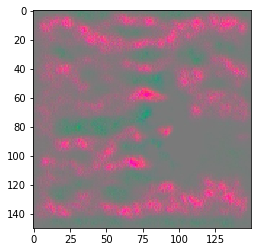

In [12]:
url="/home/seimei/Graduation_Research/src/guided_gradcam.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(150,150))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_hsv=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)/255.
plt.imshow(img_hsv)


"""
model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:0
model2:[[0.4255854  0.34738883 0.10703772 0.11998802]]
model2_get_weights():-0.4142177700996399


"""

(150, 150, 3)


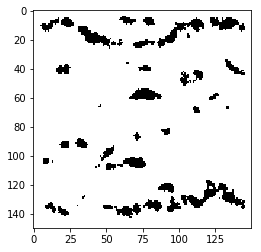

In [90]:
red_min = np.array([0,0,190], np.uint8)
red_max = np.array([255,255,255], np.uint8)
mask_red = cv2.inRange(img,red_min,red_max)
im = cv2.cvtColor(mask_red, cv2.COLOR_GRAY2RGB)
mask = cv2.bitwise_not(mask_red)
masked=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255.



print(np.shape(masked))
plt.imshow(masked)


"""
model1:1
model1:[[3.4779701e-02 9.5685458e-01 3.7951724e-04 7.9862308e-03]]
model1_get_weights():-0.4142177700996399


model2:1
model2:[[2.5324523e-04 7.8187394e-01 3.2023076e-05 2.1784082e-01]]
model2_get_weights():-0.4142177700996399


"""

In [155]:
tf.reset_default_graph()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras


In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1152391751511621215, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14299281323509105975
 physical_device_desc: "device: XLA_CPU device"]

## CNNにおける最終層の重み可視化

In [5]:
import tensorflow as tf
%tensorboard --logdir==./logs/object_classificationAB/events.out.tfevents.1549894103.1080ti 

UsageError: Line magic function `%tensorboard` not found.


## 訓練及び評価データセットについて

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
% matplotlib inline
import pandas as pd

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls

In [10]:
# 訓練用データセット分布

df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_train.csv")
df
#df['label'].apply(lambda x: ast.literal_eval(x)).tolist()
2064/16 

129.0

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None, None, None, None, None, None, None, None]

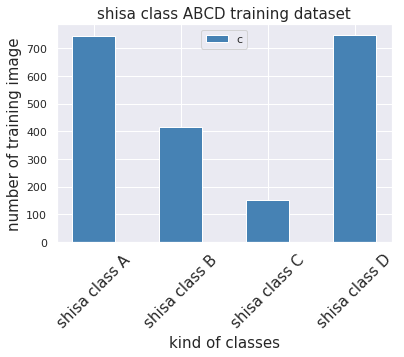

In [53]:

df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_train.csv")


all_row_num = len(df)
df = df.set_index("weather") 

left =np.array([0])
height = np.array([df.where((df["label"] == 0) & (df.index == "kumori") ).count()["label"]])
p=plt.bar(left, height,width=0.5,color='steelblue', align="center")

left1 =np.array([1])
height1 = np.array([df.where((df["label"] == 1) & (df.index == "kumori") ).count()["label"]])
p1=plt.bar(left1, height1,width=0.5,color='steelblue', align="center")

left2 =np.array([2])
height2 = np.array([df.where((df["label"] == 2) & (df.index == "kumori") ).count()["label"]])
p2=plt.bar(left2, height2,width=0.5,color='steelblue', align="center")

left3 =np.array([3])
height3 = np.array([df.where((df["label"] == 3) & (df.index == "kumori") ).count()["label"]])
p3=plt.bar(left3, height3,width=0.5,color='steelblue', align="center")

plt.xticks([0,1,2,3],["shisa class A","shisa class B","shisa class C","shisa class D"])

ax = plt.subplot(111)
    

sns.set()
plt.legend((p2),("cloudy"))
plt.xlabel("kind of classes", fontsize=15)
plt.ylabel("number of training image", fontsize=15)
plt.title("shisa class ABCD training dataset", fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15)
#plt.savefig("/Users/masaaki/Desktop/train_graph.png")

data = [go.Bar(x=)]

py.iplot(data)

In [29]:
import matplotlib
import seaborn as sns

In [6]:
matplotlib.matplotlib_fname()

'/home/seimei/.config/matplotlib/matplotlibrc'

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

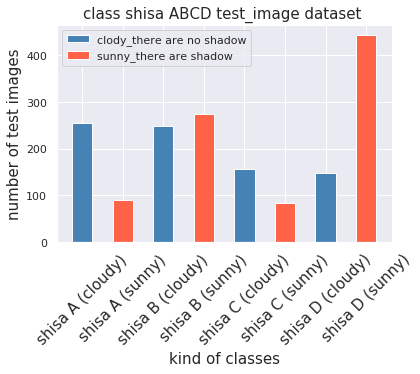

In [44]:
#　テスト用データーセット分布
df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_test.csv")
all_row_num =len(df)
df=df.set_index("weather")


left =np.array([0])
height = np.array([df.where((df["label"] == 0) & (df.index == "kumori") ).count()["label"]])
p=plt.bar(left, height,width=0.5,color='steelblue', align="center")

left1 =np.array([1])
height1 = np.array([df.where((df["label"] == 0) & (df.index == "hare") ).count()["label"]])
p1=plt.bar(left1, height1,width=0.5,color='tomato', align="center")


left2 =np.array([2])
height2 = np.array([df.where((df["label"] == 1) & (df.index == "kumori") ).count()["label"]])
p2=plt.bar(left2, height2,width=0.5,color='steelblue', align="center")

left3 =np.array([3])
height3 = np.array([df.where((df["label"] == 1) & (df.index == "hare") ).count()["label"]])
p3=plt.bar(left3, height3,width=0.5,color='tomato', align="center")


left4 =np.array([4])
height4 = np.array([df.where((df["label"] == 2) & (df.index == "kumori") ).count()["label"]])
p4=plt.bar(left4, height4,width=0.5,color='steelblue', align="center")

left5 =np.array([5])
height5 = np.array([df.where((df["label"] == 2) & (df.index == "hare") ).count()["label"]])
p5=plt.bar(left5, height5,width=0.5,color='tomato', align="center")


left6 =np.array([6])
height6 = np.array([df.where((df["label"] == 3) & (df.index == "kumori") ).count()["label"]])
p6=plt.bar(left6, height6,width=0.5,color='steelblue', align="center")

left7 =np.array([7])
height7 = np.array([df.where((df["label"] == 3) & (df.index == "hare") ).count()["label"]])
p7=plt.bar(left7, height7,width=0.5,color='tomato', align="center")



plt.xticks([0,1,2,3,4,5,6,7],["shisa A (cloudy)","shisa A (sunny)",
                              "shisa B (cloudy)","shisa B (sunny)",
                              "shisa C (cloudy)","shisa C (sunny)",
                              "shisa D (cloudy)","shisa D (sunny)"])

ax = plt.subplot(111)
sns.set()
plt.legend((p,p1),("clody_there are no shadow","sunny_there are shadow"))

plt.xlabel("kind of classes", fontsize=15)
plt.ylabel("number of test images", fontsize=15)
plt.title("class shisa ABCD test_image dataset ", fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15)

#plt.savefig("/Users/masaaki/Desktop/test_graph.png")

In [5]:
df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_test.csv")
df.head()

,weather,path,label
0,hare,/home/seimei/Graduation_Research/dataset_valid...,0
1,hare,/home/seimei/Graduation_Research/dataset_valid...,0
2,hare,/home/seimei/Graduation_Research/dataset_valid...,0
3,hare,/home/seimei/Graduation_Research/dataset_valid...,0
4,hare,/home/seimei/Graduation_Research/dataset_valid...,0


## Create Input Pipline

In [ ]:
# Serialize images, together with labels, to TF records
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

tf_records_filename = './input_pipline/OutdoorTFRecord_{}'.format(IM_SIZE)
writer = tf.python_io.TFRecordWriter(tf_records_filename)

# List of image paths, np array of labels
im_list = [os.path.join('./input_pipline/train', v+'.jpg') for v in df_train['image_name'].tolist()]
w_labels_arr = np.array([ast.literal_eval(l) for l in df_train['weather_labels']])


# Loop over images and labels, wrap in TF Examples, write away to TFRecord file
for i in range(len(df_train)):
    w_labels = w_labels_arr[i].astype(np.float32)
    im = np.array(img_to_array(load_img(im_list[i], target_size=[IM_SIZE, IM_SIZE]))/255.)
    
    example = tf.train.Example(features=tf.train.Features(feature={'image': _bytes_feature(im.tostring()),
                                                                  'weather_labels': _bytes_feature(w_labels.tostring())}))    

    writer.write(example.SerializeToString())

writer.close()    

In [1]:
url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(300,300))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

NameError: name 'cv2' is not defined

In [17]:
print(type(img_hsv))

shape=[300,300,3]
x = tf.placeholder(dtype=tf.float32, shape=shape)
flip_2 = tf.image.flip_up_down(x)

init = tf.global_variables_initializer() 
with tf.Session() as  sess:
    init.run()
    sess.run(flip_2)
    img=cv2.resize(x,(300,300))
    img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
x=cv2.imread(url)
img = cv2.resize(x,(300,300))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

<class 'numpy.ndarray'>


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_6' with dtype float and shape [300,300,3]
	 [[{{node Placeholder_6}} = Placeholder[dtype=DT_FLOAT, shape=[300,300,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node flip_up_down_6/ReverseV2/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_flip_up_down_6/ReverseV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_6', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-e30cf2c2c24f>", line 4, in <module>
    x = tf.placeholder(dtype=tf.float32, shape=shape)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5020, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_6' with dtype float and shape [300,300,3]
	 [[{{node Placeholder_6}} = Placeholder[dtype=DT_FLOAT, shape=[300,300,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node flip_up_down_6/ReverseV2/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_flip_up_down_6/ReverseV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
import keras.preprocessing.image

In [135]:
df=pd.DataFrame({"image_name":["train_0","train_1","train_2","train_3","train_4"]
              ,"tags": ["haze primary","agriculture clear primary water",
                        "clear primary","clear primary","agriculture clear habitation"]
                 ,"weather_labels":["[0,0,1,0]","[1,0,0,0]","[1,0,0,0]","[1,0,0,0]"
                                    ,"[1,0,0,0]"]
                })


In [140]:
labels = df['weather_labels'].apply(lambda x: ast.literal_eval(x)).tolist()


list

In [79]:
s=[1,1,1,1]

s=list(map(str,s))
s

['1', '1', '1', '1']

## 混合行列 >modelの性能について

In [11]:
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt

In [6]:
mnist = fetch_mldata('MNIST original')

In [7]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [8]:
type(mnist)

sklearn.utils.Bunch

In [9]:
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [14]:
%matplotlib inline

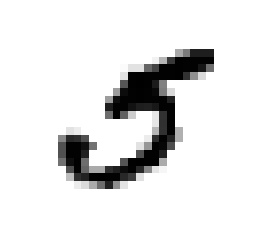

In [15]:
some_digit = x[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [16]:
y[36000]

5.0

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.activations as activations

def create_normal_model():
    model = VGG16(include_top=False, input_shape=(64,64,3), weights="imagenet")
    x = GlobalAveragePooling2D()(model.layers[-1].output)
    x = Dense(10, activation="softmax")(x)
    return Model(model.inputs ,x)


def create_batch_norm_model():
    model = create_normal_model()
    for i, layer in enumerate(model.layers):
        if i==0:
            input = layer.input
            x = input
        else:
            if "conv" in layer.name:
                layer.activation = activations.linear
                x = layer(x)
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = layer(x)
                
    bn_model = Model(input, x)
    return bn_model